In [12]:
from tqdm import tqdm
import torch
import numpy as np 
import os
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

In [13]:
# Load the Kuzushiji-49 dataset from the downloaded .npz files
train_images = np.load('k49-train-imgs.npz')['arr_0']
train_labels = np.load('k49-train-labels.npz')['arr_0']
test_images = np.load('k49-test-imgs.npz')['arr_0']
test_labels = np.load('k49-test-labels.npz')['arr_0']

In [14]:
imagedata = np.concatenate((train_images, test_images))
labeldata = np.concatenate((train_labels, test_labels))

Normalise The data

In [15]:
imagedata = imagedata.astype(np.float32) / 255.0

In [16]:
# Function to count foreground pixels
def count_foreground_pixels(image, threshold = 0):
    binary_image = image > threshold
    pixel_count = np.sum(binary_image)
    return pixel_count

In [17]:
# Calculate the median number of foreground pixels for each class
class_foreground_counts = {}
unique_labels = np.unique(labeldata)

for label in unique_labels:
    class_images = imagedata[labeldata == label]
    foreground_counts = []
    for image in class_images:
        foreground_pixel = count_foreground_pixels(image)
        foreground_counts.append(foreground_pixel)
        median_foreground_count = np.median(foreground_counts)
        class_foreground_counts[label] = median_foreground_count

In [18]:
# Create a style label for each image
style_labels =  []
style_labels = np.zeros(len(labeldata), dtype=int)
for i, (image, label) in enumerate(zip(imagedata, labeldata)):
    if count_foreground_pixels(image) > class_foreground_counts[label]:  
        style_labels[i] = 1
    else:
        style_labels[i] = 0

In [19]:
def to_one_hot(labels, num_classes):
    return torch.eye(num_classes)[label]

In [20]:
imagedata = imagedata.reshape(imagedata.shape[0], -1)

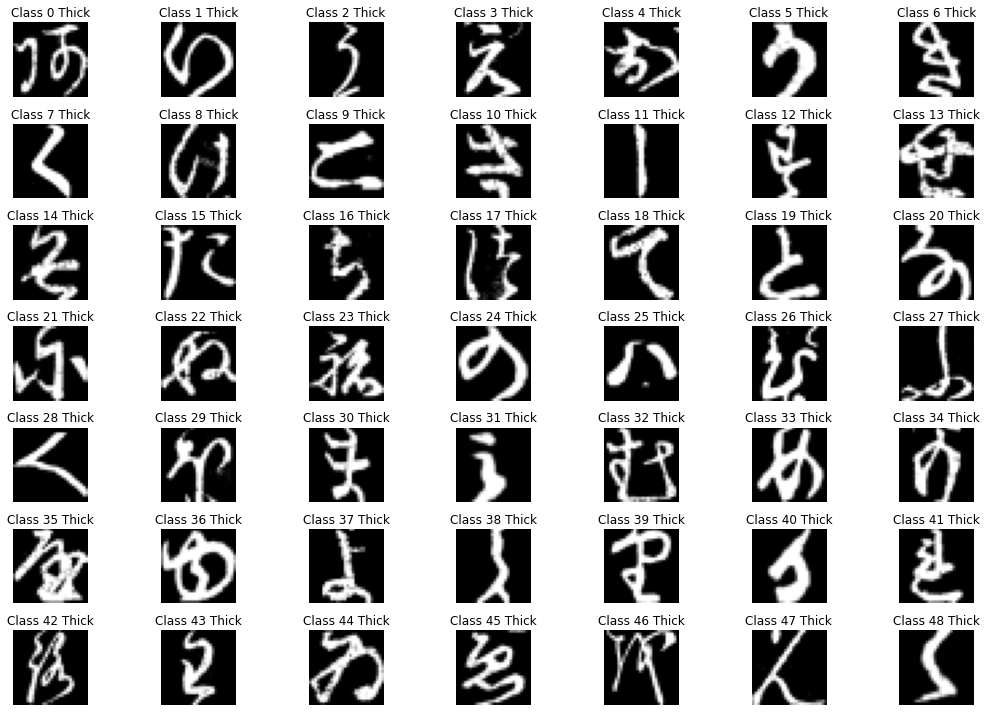

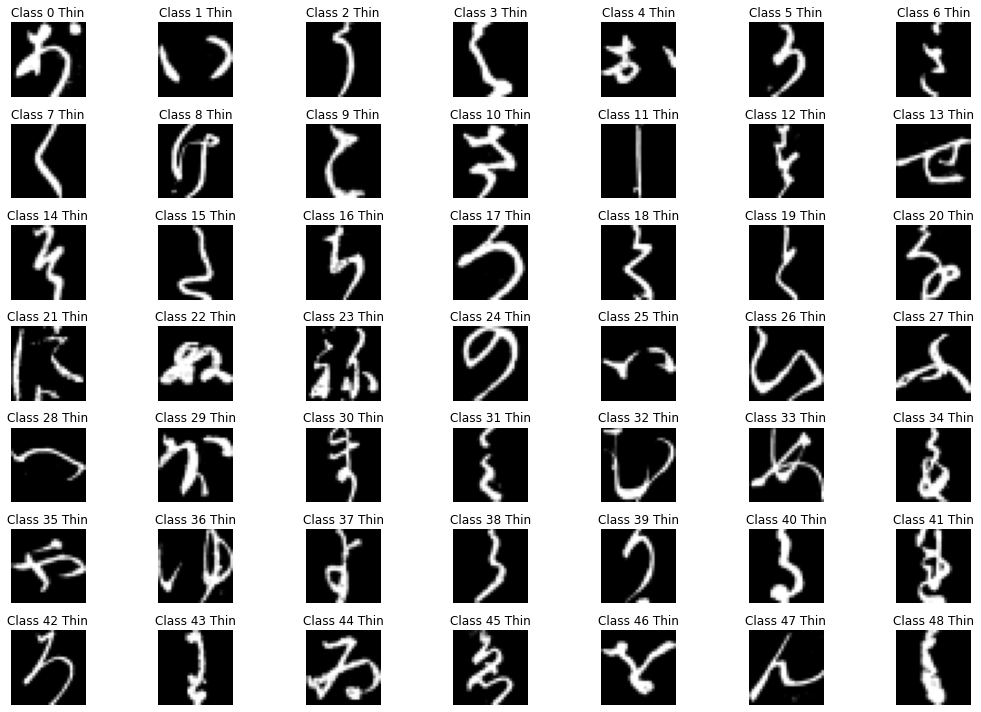

In [21]:
# Function to plot images
def plot_image(imagedata, labeldata, style_labels):
    num_classes = np.unique(labeldata).size
    
    thick = {label: None for label in np.unique(labeldata)}
    thin = {label: None for label in np.unique(labeldata)}
    
    for image, label, style_label in zip(imagedata, labeldata, style_labels):
        if style_label == 1 and thick[label] is None:
            thick[label] = image
        elif style_label == 0 and thin[label] is None:
            thin[label] = image
    
    # Adjust the figure size and subplot layout
    plt.figure(figsize=(15, 10))
    for i, label in enumerate(np.unique(labeldata)):
        if thick[label] is not None:
            plt.subplot(7, 7, i + 1)
            plt.imshow(thick[label].reshape(28, 28), cmap='gray')
            plt.title(f'Class {label} Thick')
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize = (15, 10))
    for i, label in enumerate(np.unique(labeldata)):
        if thin[label] is not None:
            plt.subplot(7, 7, i + 1)
            plt.imshow(thin[label].reshape(28, 28), cmap='gray')
            plt.title(f'Class {label} Thin')
            
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot the images
plot_image(imagedata, labeldata, style_labels)



Question 2

In [22]:
# Combine the original labels with the new style labels
combined_labels = np.vstack((labeldata, style_labels)).T


# Create TensorDataset and DataLoader for training
tensor_dataset = TensorDataset(torch.tensor(imagedata), torch.tensor(combined_labels))
data_loader = DataLoader(tensor_dataset, batch_size=128, shuffle=True)


In [23]:
#from sklearn

In [24]:
class CVAE(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
        super(CVAE, self).__init__()
        self.input_dim = input_dim
        self.label_dim = label_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # Encoder
        self.fc1 = nn.Linear(input_dim + label_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, c):
        h = F.relu(self.fc1(torch.cat([x, c], dim=1)))
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        h = F.relu(self.fc3(torch.cat([z, c], dim=1)))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

# Parameters
input_dim = 28 * 28
label_dim = 50  # 49 classes + 1 style
hidden_dim = 400
latent_dim = 20

In [25]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function
losses = []
def train(model, data_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(data_loader):
        data = data.view(-1, 28 * 28).to(device)
        class_labels = F.one_hot(labels[:, 0], num_classes=49).float().to(device)
        style_labels = labels[:, 1].float().unsqueeze(1).to(device)
        labels = torch.cat([class_labels, style_labels], dim=1)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(data_loader.dataset):.4f}')
    losses.append(train_loss / len(data_loader.dataset))

In [26]:
# Function to generate new samples
def generate(model, label, num_samples=10):
    model.eval()
    with torch.no_grad():
        class_labels = F.one_hot(torch.tensor([label] * num_samples), num_classes=49).float().to(device)
        style_labels = torch.tensor([0, 1] * (num_samples // 2)).float().unsqueeze(1).to(device)
        labels = torch.cat([class_labels, style_labels], dim=1)
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z, labels).cpu()
        return samples.view(-1, 28, 28)


In [27]:
# Directory to save images
os.makedirs('cvae_images', exist_ok=True)

In [28]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(input_dim, label_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [29]:
a_loss = []
num_epochs = 50

for epoch in range(1, num_epochs + 1):
    train(model, data_loader, optimizer, epoch)
    
    # Generate and save images
    samples = generate(model, label=0, num_samples=10)
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(samples[i], cmap='gray')
        plt.axis('off')
    plt.savefig(f'cvae_images/epoch_{epoch}.png')
    plt.close()


====> Epoch: 1 Average loss: 218.7762
====> Epoch: 2 Average loss: 192.0744
====> Epoch: 3 Average loss: 187.7621
====> Epoch: 4 Average loss: 185.4046
====> Epoch: 5 Average loss: 183.8953
====> Epoch: 6 Average loss: 182.7756
====> Epoch: 7 Average loss: 181.9557
====> Epoch: 8 Average loss: 181.3298
====> Epoch: 9 Average loss: 180.8028
====> Epoch: 10 Average loss: 180.3558
====> Epoch: 11 Average loss: 179.9483
====> Epoch: 12 Average loss: 179.6503
====> Epoch: 13 Average loss: 179.3473
====> Epoch: 14 Average loss: 179.0917
====> Epoch: 15 Average loss: 178.8772
====> Epoch: 16 Average loss: 178.6785
====> Epoch: 17 Average loss: 178.4996
====> Epoch: 18 Average loss: 178.3412
====> Epoch: 19 Average loss: 178.1835
====> Epoch: 20 Average loss: 178.0180
====> Epoch: 21 Average loss: 177.8929
====> Epoch: 22 Average loss: 177.7591
====> Epoch: 23 Average loss: 177.6455
====> Epoch: 24 Average loss: 177.5436
====> Epoch: 25 Average loss: 177.4481
====> Epoch: 26 Average loss: 177.

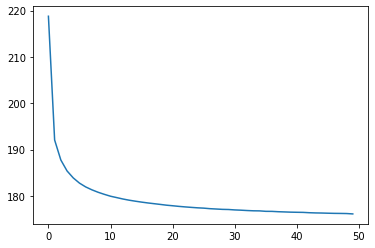

In [55]:
plt.plot(losses)

In [30]:
# Save the trained model
torch.save(model.state_dict(), 'cvae_model.pth')

In [31]:
# To load the model later
#model = CVAE(input_dim, label_dim, hidden_dim, latent_dim).to(device)
model.load_state_dict(torch.load('cvae_model.pth'))
model.eval()

CVAE(
  (fc1): Linear(in_features=834, out_features=400, bias=True)
  (fc2_mu): Linear(in_features=400, out_features=20, bias=True)
  (fc2_logvar): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=70, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)

In [32]:
# Directory to save images
os.makedirs('cvae_images', exist_ok=True)


In [33]:
# Function to generate new samples
def generate(model, label, num_samples=20):
    model.eval()
    with torch.no_grad():
        class_labels = F.one_hot(torch.tensor([label] * num_samples), num_classes=49).float().to(device)
        style_labels = torch.tensor([0, 1] * (num_samples // 2)).float().unsqueeze(1).to(device)
        labels = torch.cat([class_labels, style_labels], dim=1)
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z, labels).cpu()
        return samples.view(-1, 28, 28)


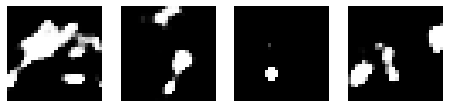

In [82]:
# Generate and plot new samples
samples = generate(model, label=4, num_samples=4)
plt.figure(figsize=(20, 3))
for i in range(4):
    plt.subplot(1, 10, i + 1)
    plt.imshow(samples[i], cmap='gray')
    plt.axis('off')
    plt.savefig(f'generated_epoch{num_epochs}.png')
plt.show()


In [35]:
# Save the trained model
torch.save(model.state_dict(), 'cvae_model.pth')

Question 3

In [36]:
# Define the Generator class
class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, img_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, img_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        input = torch.cat((noise, labels), -1)
        return self.model(input)

In [37]:
# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self, img_dim, label_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim + label_dim, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        input = torch.cat((img, labels), -1)
        return self.model(input)


In [38]:
# Hyperparameters
noise_dim = 100
label_dim = 50  # 49 classes + 1 style
img_dim = 28 * 28
batch_size = 128
lr = 0.0002  # Adjusted learning rate
num_epochs = 50

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# Create the generator and discriminator
generator = Generator(noise_dim, label_dim, img_dim).to(device)
discriminator = Discriminator(img_dim, label_dim).to(device)

In [41]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [42]:
# Loss function
adversarial_loss = nn.BCELoss()

In [43]:
# Create TensorDataset and DataLoader for training
imagedata = imagedata*2-1
tensor_dataset = TensorDataset(torch.tensor(imagedata), torch.tensor(combined_labels))
data_loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

In [44]:
os.makedirs('cgan_images', exist_ok=True)

In [45]:
d_losses = []
g_losses = []
# Training function
def train_cgan(generator, discriminator, data_loader, optimizer_G, optimizer_D, epoch, num_epochs):
    for epoch in range(epoch, num_epochs + 1):
        for batch_idx, (data, labels) in enumerate(data_loader):
            batch_size = data.size(0)
            real = torch.ones(batch_size, 1).to(device) * 0.9  # Label smoothing for real labels
            fake = torch.zeros(batch_size, 1).to(device)

            real_imgs = data.view(batch_size, -1).to(device)
            labels = labels.long()  # Ensure labels are in integer format
            class_labels = F.one_hot(labels[:, 0], num_classes=49).float().to(device)
            style_labels = labels[:, 1].float().unsqueeze(1).to(device)
            labels = torch.cat([class_labels, style_labels], dim=1)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_validity = discriminator(real_imgs, labels)
            d_real_loss = adversarial_loss(real_validity, real)

            noise = torch.randn(batch_size, noise_dim).to(device)
            gen_labels = labels
            gen_imgs = generator(noise, gen_labels)
            fake_validity = discriminator(gen_imgs.detach(), gen_labels)
            d_fake_loss = adversarial_loss(fake_validity, fake)

            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            validity = discriminator(gen_imgs, gen_labels)
            g_loss = adversarial_loss(validity, real)
            g_loss.backward()
            optimizer_G.step()

            if batch_idx % 2117 == 0:
                print(f'Epoch [{epoch}/{num_epochs}] Batch [{batch_idx}/{len(data_loader)}] '
                      f'D Loss: {d_loss.item():.4f} G Loss: {g_loss.item():.4f}')
                d_losses.append(d_loss.item())
                g_losses.append(g_loss.item())
              
                save_combined_images(real_imgs, gen_imgs, epoch, batch_idx)   
            

In [46]:
def save_combined_images(real_imgs, gen_imgs, epoch, batch_idx, nrow=8, directory='cgan_images'):
    real_imgs = real_imgs.view(real_imgs.size(0), 1, 28, 28)
    gen_imgs = gen_imgs.view(gen_imgs.size(0), 1, 28, 28)
    
    real_grid = make_grid(real_imgs, nrow=nrow, normalize=True, padding=2)
    gen_grid = make_grid(gen_imgs, nrow=nrow, normalize=True, padding=2)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(real_grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    axs[0].set_title('Orginal Images')
    axs[0].axis('off')

    axs[1].imshow(gen_grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    axs[1].set_title('Generated Images')
    axs[1].axis('off')

    fig.suptitle(f'Epoch {epoch} Batch {batch_idx}', fontsize=16)
    
    # Save the figure
    save_path = f'{directory}/combined_epoch_{epoch}_batch_{batch_idx}.png'
    fig.savefig(save_path)
    
    plt.close(fig)

In [47]:
# Directory to save images
os.makedirs('cgan_images', exist_ok=True)

In [48]:
# Training loop
train_cgan(generator, discriminator, data_loader, optimizer_G, optimizer_D, 1, num_epochs)

Epoch [1/50] Batch [0/2117] D Loss: 0.6928 G Loss: 0.6982
Epoch [2/50] Batch [0/2117] D Loss: 0.4759 G Loss: 3.1979
Epoch [3/50] Batch [0/2117] D Loss: 0.4546 G Loss: 1.6546
Epoch [4/50] Batch [0/2117] D Loss: 0.5208 G Loss: 1.1735
Epoch [5/50] Batch [0/2117] D Loss: 0.6139 G Loss: 2.6167
Epoch [6/50] Batch [0/2117] D Loss: 0.5074 G Loss: 2.0789
Epoch [7/50] Batch [0/2117] D Loss: 0.5437 G Loss: 1.7979
Epoch [8/50] Batch [0/2117] D Loss: 0.5277 G Loss: 1.2580
Epoch [9/50] Batch [0/2117] D Loss: 0.5466 G Loss: 1.4198
Epoch [10/50] Batch [0/2117] D Loss: 0.5878 G Loss: 1.5306
Epoch [11/50] Batch [0/2117] D Loss: 0.5535 G Loss: 1.7110
Epoch [12/50] Batch [0/2117] D Loss: 0.5756 G Loss: 1.6567
Epoch [13/50] Batch [0/2117] D Loss: 0.5367 G Loss: 1.6398
Epoch [14/50] Batch [0/2117] D Loss: 0.5497 G Loss: 1.4891
Epoch [15/50] Batch [0/2117] D Loss: 0.5551 G Loss: 1.3522
Epoch [16/50] Batch [0/2117] D Loss: 0.5360 G Loss: 1.2392
Epoch [17/50] Batch [0/2117] D Loss: 0.5925 G Loss: 1.7835
Epoch 

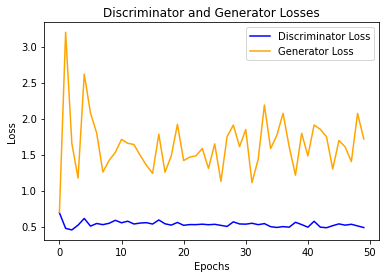

In [79]:
# Plot d_losses
plt.plot(d_losses, label='Discriminator Loss', color='blue')

# Plot g_losses
plt.plot(g_losses, label='Generator Loss', color='orange')

# Adding title and labels
plt.title('Discriminator and Generator Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Adding a legend
plt.legend()
plt.savefig(f'l_Curve1.png')

# Show the plot
plt.show()

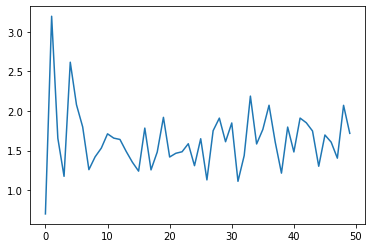

In [74]:
torch.save(generator.state_dict(), 'cgan.pth')

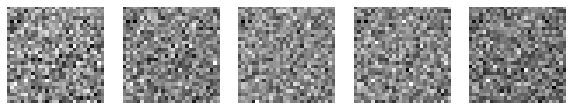

In [78]:
class Generator(nn.Module):
    def __init__(self, noise_dim, class_dim, style_dim, img_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + class_dim + style_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, img_dim),
            nn.Tanh()
        )

    def forward(self, noise, class_labels, style_labels):
        input = torch.cat((noise, class_labels, style_labels), -1)
        return self.model(input)

# Parameters (adjust as needed)
latent_dim = 100  # Dimension of the latent space
class_dim = 10    # Number of class labels (one-hot encoded size)
style_dim = 5     # Number of style labels (one-hot encoded size)
img_dim = 28 * 28 # Size of the flattened image (for 28x28 images)

# Load the trained generator model
generator = Generator(latent_dim, class_dim, style_dim, img_dim)
generator.load_state_dict(torch.load('cgan.pth', map_location=torch.device('cuda')))
generator.eval()  # Set the generator to evaluation mode

# Generate random noise
num_images = 5  # Number of images to generate
noise = torch.randn(num_images, latent_dim)

# Generate random class and style labels (adjust according to your use case)
class_labels = torch.eye(class_dim)[torch.randint(0, class_dim, (num_images,))]  # One-hot encoded random class labels
style_labels = torch.eye(style_dim)[torch.randint(0, style_dim, (num_images,))]  # One-hot encoded random style labels

# Generate images
with torch.no_grad():
    generated_images = generator(noise, class_labels, style_labels)

# Convert generated images to a format suitable for visualization
generated_images = generated_images.view(-1, 28, 28).cpu().numpy()

# Plot and save the generated images
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
for i in range(num_images):
    ax = axes[i]
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')

plt.show()
